In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import pdb
# warnings.filterwarnings('ignore')

In [5]:
# ----- LOAD DATA -----
data = pd.read_csv('all_annotations.csv')

# ----- FIGURES -----
outp = os.path.join('figures','2024September','committee')

# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

# set hue order
ho = ['WT','Het']

In [3]:
# ----- TRANSITION MATRIX FUNCTION -----
def calculate_transition_matrix(data,normaxis):
    
    # use data to extract transitions
    data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior
    transitions = data.groupby(['behavior', 'next_behav']) # organize by unique behavior transitions
    counts = {i[0]:len(i[1]) for i in transitions} # count up instances of transitions
    
    # generate behavior x behavior matrix
    behavs = sorted(data.behavior.unique())
    matrix = pd.DataFrame()

    for x in behavs: # count up transition numbers
        matrix[x] = pd.Series([counts.get((x,y), 0) for y in behavs], index=behavs)        
        
    cols = matrix.columns
    
    # calculate probabilities across row
    matrix[cols] = matrix[cols].div(matrix[cols].sum(axis=normaxis), axis=normaxis)
    
    return matrix

def filter_data_and_calculate_transitions(data,assay,sex,gt,normaxis):
    
    adf = data[data.assay==assay]
    filt = adf[np.logical_and(adf.sex==sex,adf.GT==gt)]
       
    tmatrix = calculate_transition_matrix(filt,normaxis)
    
    return tmatrix

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


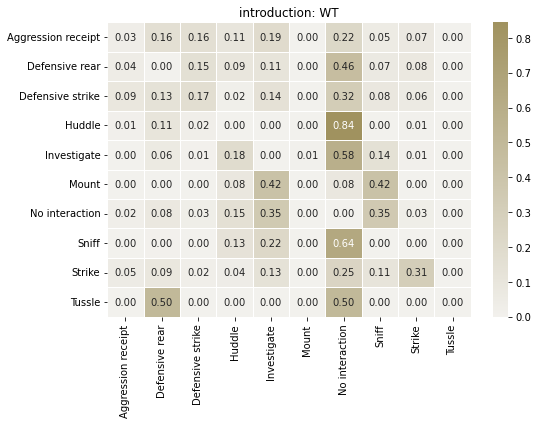

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


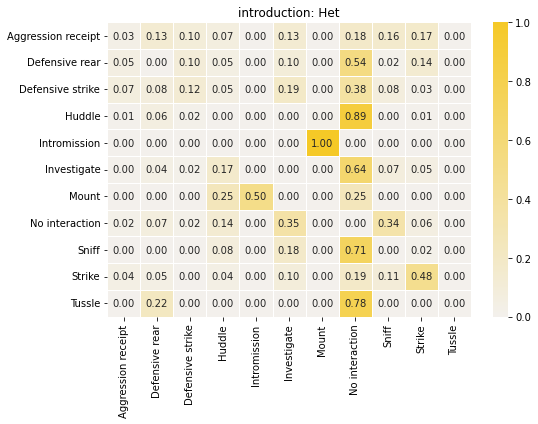

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


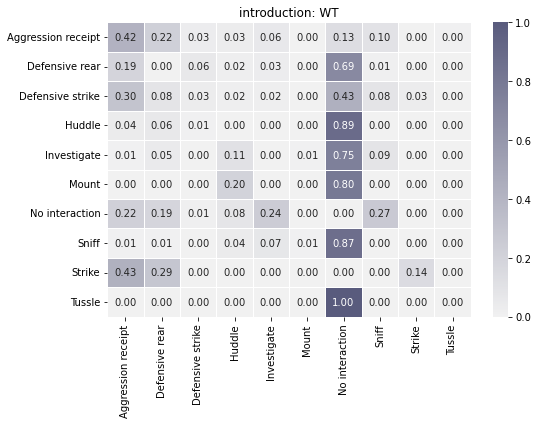

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


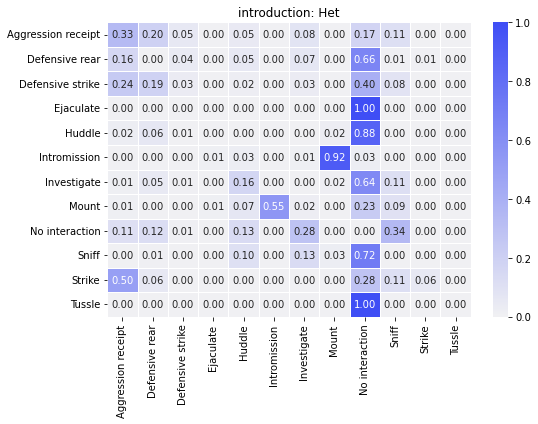

In [11]:
# ----- MAKE TRANSITION MATRICES FOR INTROS -----

assays = ['introduction']
sexes = ['F','M']
genotypes = ['WT','Het']
normaxis = 1
saveplots = True

cc = 0

for i,sex in enumerate(sexes):
    for j,gt in enumerate(genotypes):
        for assay in assays:
            upal = sns.light_palette(acols[cc], as_cmap=True)
            tmat = filter_data_and_calculate_transitions(data,assay,sex,gt,normaxis)
            fig = plt.figure(figsize=(8, 6))
            hmap = sns.heatmap(tmat.transpose(),cmap=upal,annot=True,linewidth=.5,fmt=".2f")
            ttl = f'{assay}: {gt}'
            hmap.set(title=ttl)
            fname = f'transitionProbs_{assay}_{sex}_{gt}_transpose_normaxis{normaxis}.png'
            plt.tight_layout()
            plt.show()
            if np.logical_and(saveplots,sex=='M'):
                fig.savefig(os.path.join(outp,fname))

        cc+=1

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


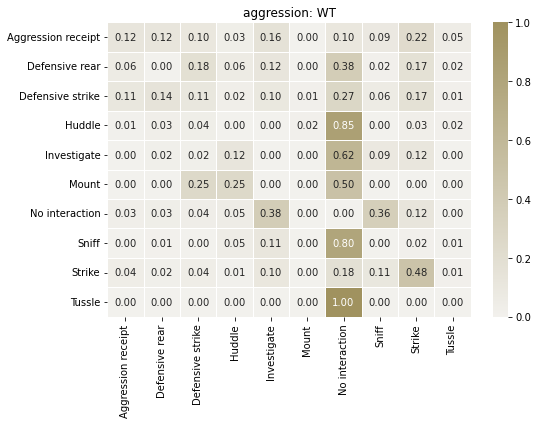

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


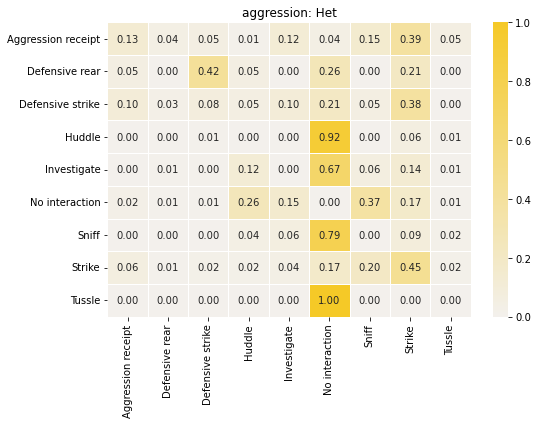

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


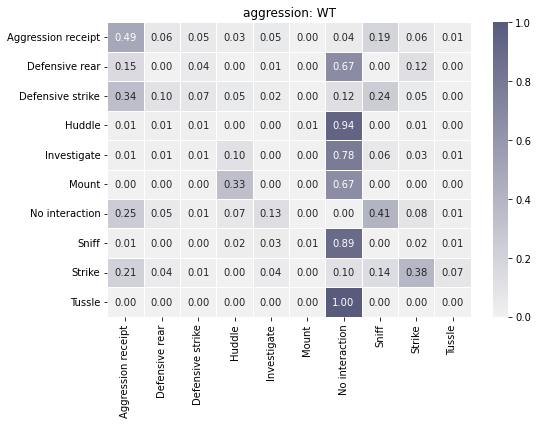

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_16788\2333000662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_behav'] = data.groupby('pair_tag').behavior.shift(periods=-1) # generate match of behavior to next behavior


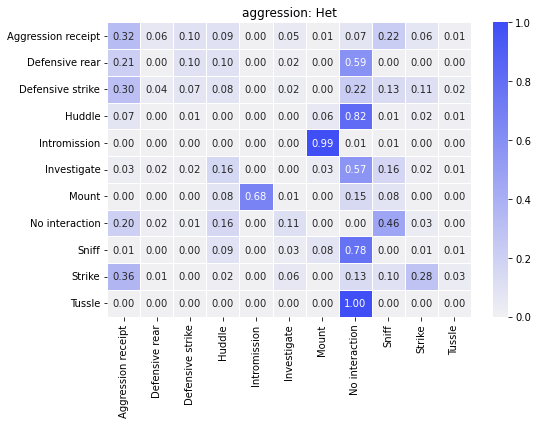

In [19]:
# ----- MAKE TRANSITION MATRICES FOR INTROS -----

assays = ['aggression']
sexes = ['F','M']
genotypes = ['WT','Het']
normaxis = 1
saveplots = True

cc = 0

for i,sex in enumerate(sexes):
    for j,gt in enumerate(genotypes):
        for assay in assays:
            upal = sns.light_palette(acols[cc], as_cmap=True)
            tmat = filter_data_and_calculate_transitions(data,assay,sex,gt,normaxis)
            fig = plt.figure(figsize=(8, 6))
            hmap = sns.heatmap(tmat.transpose(),cmap=upal,annot=True,linewidth=.5,fmt=".2f")
            ttl = f'{assay}: {gt}'
            hmap.set(title=ttl)
            fname = f'transitionProbs_{assay}_{sex}_{gt}_transpose_normaxis{normaxis}.png'
            plt.tight_layout()
            plt.show()
            if np.logical_and(saveplots,sex=='M'):
                fig.savefig(os.path.join(outp,fname))

        cc+=1

In [9]:
# -----  SET UP DATA FOR SNIFFS -----
# add next behavior to table
data['next_behav'] = data.groupby(['pair_tag','assay']).behavior.shift(periods=-1) # generate match of behavior to next behavior

# filter to sniffs
sniffs = data[data.behavior=='Sniff']

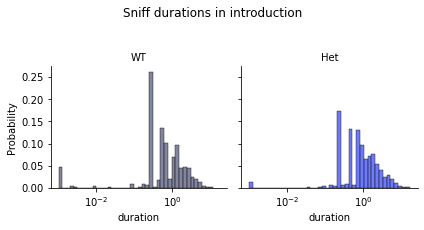

In [10]:
# ----- DURATION DISTRIBUTIONS OF ALL INTRO SNIFFS, PROBABILITY -----
sex='M'
assay='introduction'
behavior = 'Sniff'
tdat = sniffs[sniffs.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1
usestat = 'probability'

fname = f'duration_distribution_{assay}_{sex}_{behavior}_{usestat}.png'

g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

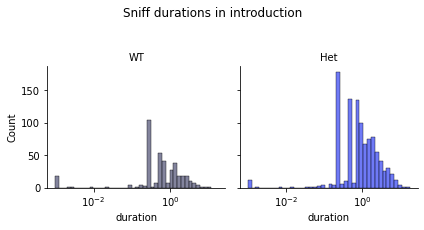

In [12]:
# ----- DURATION DISTRIBUTIONS OF ALL INTRO SNIFFS, COUNTS -----
sex='M'
assay='introduction'
behavior = 'Sniff'
tdat = sniffs[sniffs.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1
usestat = 'count'

fname = f'duration_distribution_{assay}_{sex}_{behavior}_{usestat}.png'


g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

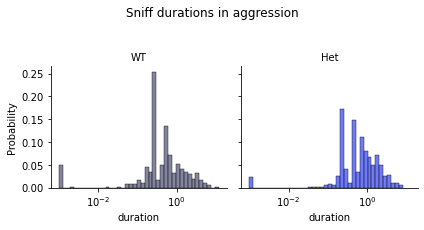

In [13]:
# ----- DURATION DISTRIBUTIONS OF ALL AGGRESSION SNIFFS, PROBABILITY -----
sex='M'
assay='aggression'
behavior = 'Sniff'
tdat = sniffs[sniffs.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1
usestat = 'probability'

fname = f'duration_distribution_{assay}_{sex}_{behavior}_{usestat}.png'

g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

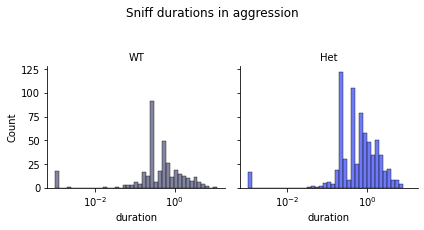

In [14]:
# ----- DURATION DISTRIBUTIONS OF ALL AGGRESSION SNIFFS, COUNTS -----
sex='M'
assay='aggression'
behavior = 'Sniff'
tdat = sniffs[sniffs.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1

usestat = 'count'
fname = f'duration_distribution_{assay}_{sex}_{behavior}_{usestat}.png'

g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

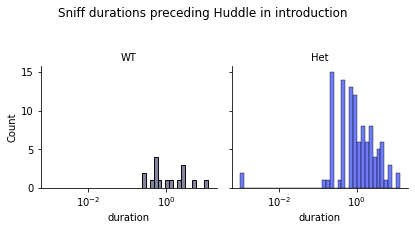

In [15]:
# ----- SNIFF TO HUDDLE TRANSITIONS, INTROS, COUNTS -----

sex='M'
assay='introduction'
behavior = 'Sniff'
useb = ['Huddle']
usestat = 'count'


bdf = sniffs[sniffs.next_behav.isin(useb)]
tdat = bdf[bdf.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1

fname = f'duration_distribution_{assay}_{sex}_{behavior}preceding{useb[0]}_{usestat}.png'

g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations preceding {useb[0]} in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

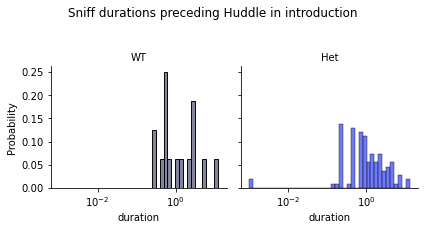

In [16]:
# ----- SNIFF TO HUDDLE TRANSITIONS, INTROS, PROBABILITIES -----

sex='M'
assay='introduction'
behavior = 'Sniff'
useb = ['Huddle']
usestat = 'probability'

bdf = sniffs[sniffs.next_behav.isin(useb)]
tdat = bdf[bdf.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1

fname = f'duration_distribution_{assay}_{sex}_{behavior}preceding{useb[0]}_{usestat}.png'


g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations preceding {useb[0]} in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

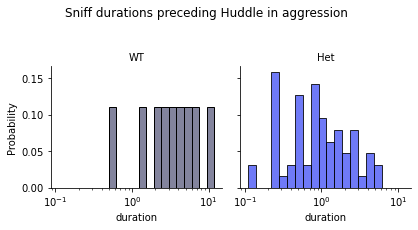

In [17]:
# ----- SNIFF TO HUDDLE TRANSITIONS, AGGRESSION, PROBABILITIES -----

sex='M'
assay='aggression'
behavior = 'Sniff'
useb = ['Huddle']
usestat = 'probability'

bdf = sniffs[sniffs.next_behav.isin(useb)]
tdat = bdf[bdf.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1

fname = f'duration_distribution_{assay}_{sex}_{behavior}preceding{useb[0]}_{usestat}.png'

g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations preceding {useb[0]} in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

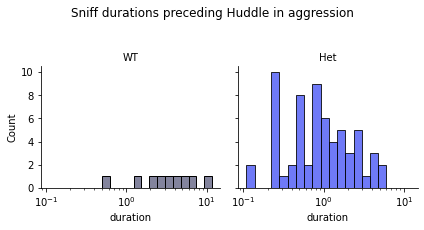

In [18]:
# ----- SNIFF TO HUDDLE TRANSITIONS, AGGRESSION, COUNTS -----

sex='M'
assay='aggression'
behavior = 'Sniff'
useb = ['Huddle']
usestat = 'count'

bdf = sniffs[sniffs.next_behav.isin(useb)]
tdat = bdf[bdf.sex==sex] # males only
tdat = tdat[tdat.assay==assay]
tdat = tdat[tdat.duration!=0]
pal = mpal
bw = 0.1

fname = f'duration_distribution_{assay}_{sex}_{behavior}preceding{useb[0]}_{usestat}.png'


g = sns.FacetGrid(tdat, col="GT",  hue='GT', hue_order=ho,palette=mpal,col_order=ho)
g.map(sns.histplot,
         'duration',
         fill=True, 
         binwidth=bw,
         stat=usestat,
         element='bars',
         log_scale=(10,None),
         common_norm=False,)
g.set_titles(col_template="{col_name}")
g.fig.suptitle(f'{behavior} durations preceding {useb[0]} in {assay}',y=1.05)
plt.tight_layout()
if saveplots:
    g.savefig(os.path.join(outp,fname))

In [73]:
# FISHER'S EXACT FOR HUDDLE VERSUS NON HUDDLE SNIFFS
intro = data[data.assay=='introduction']
introm = intro[intro.sex=='M']
intromsniff = introm[introm.behavior=='Sniff']
intromtrx = pd.crosstab(intromsniff['GT'], intromsniff['next_behav'].eq('Huddle'))
introchi2 = st.chi2_contingency(mtrx)
print(mtrx)
print(introchi2[1])

next_behav  False  True 
GT                      
Het           923    108
WT            386     16
0.00013110937815225912


In [74]:
# FISHER'S EXACT FOR HUDDLE VERSUS NON HUDDLE SNIFFS
aggr = data[data.assay=='aggression']
aggrm = aggr[aggr.sex=='M']
aggrmsniff = aggrm[aggrm.behavior=='Sniff']
aggrmtrx = pd.crosstab(aggrmsniff['GT'], aggrmsniff['next_behav'].eq('Huddle'))
aggrchi2 = st.chi2_contingency(aggrmtrx)
print(aggrmtrx)
print(aggrchi2[1])

next_behav  False  True 
GT                      
Het           649     63
WT            354      9
0.00013264773306540602
